In [1]:
import sys
sys.path.append('/Users/jpnousu/pyAPES_main')
from pyAPES.snow.pyFSM2.snow import SnowModel
from pyAPES.snow.pyFSM2.srfebal import EnergyBalance
from pyAPES.snow.pyFSM2.soil import SoilModel
from pyAPES.snow.pyFSM2.thermal import Thermal
from pyAPES.snow.pyFSM2.swrad import SWrad
from pyAPES.snow.pyFSM2.solarpos import SolarPos


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from datetime import datetime
from pyAPES.utils.iotools import read_forcing
from pyAPES.parameters.mlm_parameters import gpara, cpara, spara, fsm2 # model configuration, canopy parameters, soil parameters

KELVIN = 273.15

In [2]:
# Manipulating the params to correspond to those of Degerö
gpara['forc_filename'] = r'/Users/jpnousu/pyAPES_main/forcing/Degero/Degero_forcing_2014-2016.dat'
gpara['start_time'] = '2014-09-01'
gpara['end_time'] = '2015-09-01'

# Reading the forcing file
forcing = read_forcing(
    forcing_file=gpara['forc_filename'],
    start_time=gpara['start_time'],
    end_time=gpara['end_time'],
    dt=gpara['dt']
)

forcing['Rainf'] = forcing['Prec'].where(forcing['Tair'] > 1, 0)
forcing['Snowf'] = forcing['Prec'].where(forcing['Tair'] <= 1, 0)
forcing['DIR_SWdown'] = forcing['diffNir'] + forcing['diffPar'] + forcing['dirNir'] + forcing['dirPar']
forcing['HUMREL'] = 80.
forcing['PSurf'] = 10000.
forcing['Tair_K'] = forcing['Tair'] + KELVIN

In [3]:
#fforc = r'/Users/jpnousu/FSM2/met_Sod_1314.txt'
#fout = r'/Users/jpnousu/FSM2/Sod_1314_stat.txt'
#foutf = r'/Users/jpnousu/FSM2/Sod_1314_flux.txt'
#forc = pd.read_csv(fforc, header=None, delimiter=r"\s+", index_col=0, parse_dates={'time': [0,1,2,3]}, date_parser=lambda x: datetime.strptime(x, '%Y %m %d %H'))
#out = pd.read_csv(fout, header=None, delimiter=r"\s+")
#outf = pd.read_csv(foutf, header=None, delimiter=r"\s+")
#col_names = ['DIR_SWdown', 'LWdown', 'Snowf', 'Rainf', 'Tair', 'HUMREL', 'Wind', 'PSurf']
#forc.columns = col_names

In [4]:
ebal = EnergyBalance(fsm2)
soil = SoilModel(fsm2)
snow = SnowModel(fsm2)
thermal = Thermal(fsm2)
swrad = SWrad(fsm2)
solarpos = SolarPos()

In [5]:
dt = 3600

snow_states = {'Sice': snow.Sice,
               'Sliq': snow.Sliq,
               'Nsnow': snow.Nsnow,
               'Dsnw': snow.Dsnw,
               'Tsnow': snow.Tsnow}

soil_states = {'Tsoil': soil.Tsoil,
               'Vsmc': soil.Vsmc,
               }
ebal_states = {'Tsrf': ebal.Tsrf}

# outputs
Tsoillist = []
Ts1list = []
swelist = []
SWsrflist = []
SWoutlist = []
hslist = []
Meltlist = []
Gsrflist = []
Rofflist = []
Esrflist = []
Hlist = []
LElist = []
subllist = []
Tsrflist = []
LWoutlist = []
ksnowlist = []
Gsoillist = []
Nsnowlist = []
ks1list = []
ksnowlist = []
ksoillist = []
Dsnwlist = []
Sicelist = []
Sliqlist = []
Vsmclist = []
Tsnowlist = []
fsnowlist = []

for i in range(len(forcing)):
#for i in range(1000):
    
    d_forc = forcing.iloc[i]
    #d_forc = forc.isel(time=i)

    #print('step', i)

    LW = np.array(d_forc['LWin'].data)
    Ps = np.array(d_forc['PSurf'].data)
    SWsrf = np.array(d_forc['DIR_SWdown'].data)
    Ta = np.array(d_forc['Tair_K'].data)
    #Ta_K = np.array(d_forc['Tair_K'].data)
    Rf = np.array(d_forc['Rainf'].data)
    Sf = np.array(d_forc['Snowf'].data)
    Ua = np.array(d_forc['U'].data)
    RH = np.array(d_forc['HUMREL'].data)

    swrad_forcing = {'Sdif': SWsrf*1.0,
                    'Sdir': 0, #SWsrf*0.7,
                    'Sf': Sf,
                    'Tsrf': ebal_states['Tsrf'],
                    'Dsnw': snow_states['Dsnw'],
                    'alb0': fsm2['soilprops']['alb0']}

    swrad_fluxes, swrad_states = swrad.run(dt, swrad_forcing)
    
    thermal_forcing = {'Nsnow': snow_states['Nsnow'],
                       'Dsnw': snow_states['Dsnw'],
                       'Sice': snow_states['Sice'],
                       'Sliq': snow_states['Sliq'],
                       'Tsnow': snow_states['Tsnow'],
                       'Tsoil': soil_states['Tsoil'],
                       'Vsmc': soil_states['Vsmc']}

    thermal_fluxes, thermal_states = thermal.run(thermal_forcing)

    ebal_forcing = {'Ds1': thermal_states['Ds1'],
                    'fsnow': swrad_states['fsnow'],
                    'gs1': thermal_states['gs1'],
                    'ks1': thermal_states['ks1'],
                    'LW': LW,
                    'Ps': Ps,
                    'RH': RH,
                    'SWsrf': swrad_fluxes['SWsrf'],
                    'Ta': Ta,
                    'Ts1': thermal_states['Ts1'],
                    'Ua': Ua,
                    'Sice': snow_states['Sice'],
                    'Sliq': snow_states['Sliq'],
                    'Nsnow': snow_states['Nsnow'],
                    'Dsnw': snow_states['Dsnw'],
                    'reference_height': fsm2['params']['zU'],
                    'Tsrf': ebal_states['Tsrf'],
                    'z0sf': fsm2['params']['z0sf']
                    }
    
    ebal_fluxes, ebal_states = ebal.run(dt, ebal_forcing)

    snow_forcing = {'drip': 0,
                    'Esrf': ebal_fluxes['Esrf'],
                    'Gsrf': ebal_fluxes['Gsrf'],
                    'ksoil': thermal_states['ksoil'][0],
                    'ksnow': thermal_states['ksnow'],
                    'Melt': ebal_fluxes['Melt'],
                    'Rf': Rf,
                    'Sf': Sf,
                    'Ta': Ta,
                    'trans': 0,
                    'Tsrf': ebal_states['Tsrf'],
                    'unload': 0,
                    'Tsoil': soil_states['Tsoil'][0],
                    'ksnow': thermal_states['ksnow'],
                    'Dzsoil': soil.Dzsoil[0]
                    }
    snow_fluxes, snow_states = snow.run(dt, snow_forcing)

    soil_forcing = {'Gsoil': snow_fluxes['Gsoil'],
                    'csoil': thermal_states['csoil'],
                    'ksoil': thermal_states['ksoil']}
    soil_fluxes, soil_states = soil.run(dt, soil_forcing)

    swelist.append(snow_states['swe'])
    hslist.append(snow_states['hs'])
    Meltlist.append(ebal_fluxes['Melt'])
    Gsrflist.append(ebal_fluxes['Gsrf'])
    Gsoillist.append(snow_fluxes['Gsoil'])
    Rofflist.append(snow_fluxes['Roff'])
    Tsoillist.append(soil_states['Tsoil'][0])
    Tsrflist.append(ebal_states['Tsrf'])
    SWsrflist.append(swrad_fluxes['SWsrf'])
    SWoutlist.append(swrad_fluxes['SWout'])
    subllist.append(ebal_fluxes['subl'])
    Ts1list.append(thermal_states['Ts1'])
    Esrflist.append(ebal_fluxes['Esrf'])
    Hlist.append(ebal_fluxes['H'])
    LElist.append(ebal_fluxes['LE'])
    LWoutlist.append(ebal_fluxes['LWout'])
    Nsnowlist.append(snow_states['Nsnow'])
    ks1list.append(thermal_states['ks1'])
    ksoillist.append(thermal_states['ksoil'][0])
    ksnowlist.append(thermal_states['ksnow'][0])
    Dsnwlist.append(snow_states['Dsnw'][0])
    Sicelist.append(snow_states['Sice'][0])
    Sliqlist.append(snow_states['Sliq'][0])
    Vsmclist.append(soil_states['Vsmc'][0])
    Tsnowlist.append(snow_states['Tsnow'][0])
    fsnowlist.append(swrad_states['fsnow'])



In [6]:
#plt.plot(Gsrflist)
#lt.plot(LElist)
#plt.plot(Hlist)
#plt.plot(Esrflist)
#plt.plot(subllist)
#plt.plot(LWoutlist)
#plt.plot(SWsrflist)
#plt.plot(Gsoillist)

Text(0, 0.5, 'Snow depth [m]')

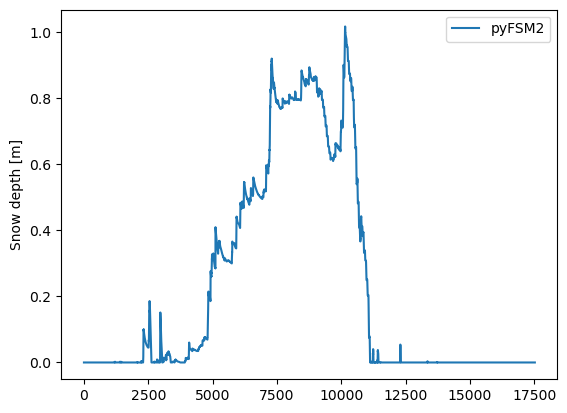

In [6]:
plt.plot(hslist, label='pyFSM2')
#plt.plot(out.iloc[:,4].values, linestyle='--', label='FSM2')
plt.legend()
plt.ylabel('Snow depth [m]')

Text(0, 0.5, 'SWE')

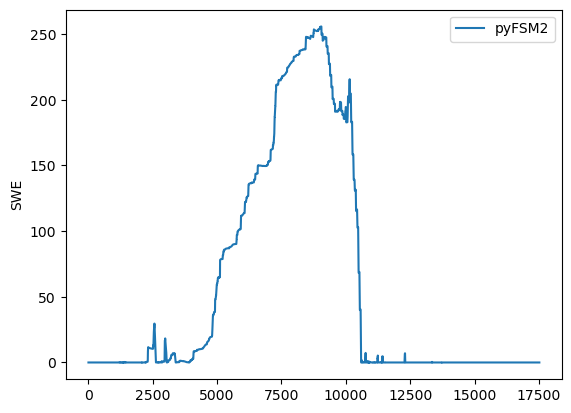

In [6]:
plt.plot(swelist, label='pyFSM2')
#plt.plot(out.iloc[:,5].values, linestyle='--', label='FSM2')
plt.legend()
plt.ylabel('SWE')

Text(0, 0.5, 'Tsoil')

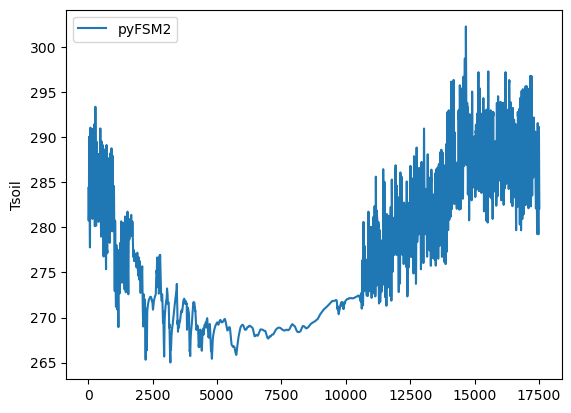

In [10]:
plt.plot(Tsoillist, label='pyFSM2')
#plt.plot(out.iloc[:,7].values, linestyle='--', alpha=0.5, label='FSM2')
plt.legend()
plt.ylabel('Tsoil')

Text(0, 0.5, 'H')

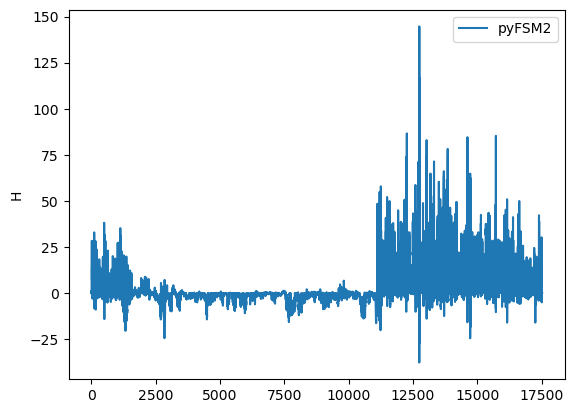

In [10]:
plt.plot(Hlist, label='pyFSM2')
#plt.plot(outf.iloc[:,4].values, linestyle='--', alpha=0.5, label='FSM2')
plt.legend()
plt.ylabel('H')

Text(0, 0.5, 'LE')

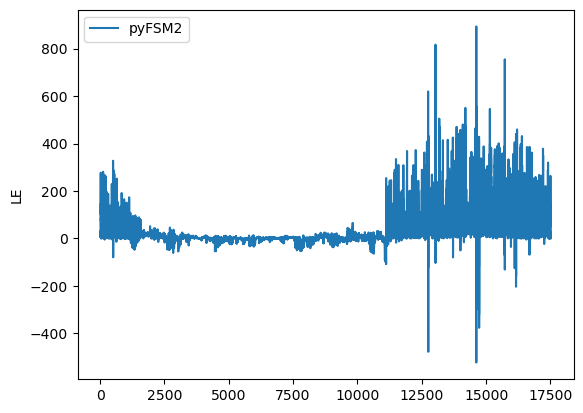

In [11]:
plt.plot(LElist, label='pyFSM2')
#plt.plot(outf.iloc[:,5].values, linestyle='--', alpha=0.5, label='FSM2')
plt.legend()
plt.ylabel('LE')

In [12]:
plt.scatter(LElist[2000:4000], outf.iloc[2000:4000,5].values, s=3)
plt.xlabel('pyFSM2')
plt.ylabel('FSM2')

NameError: name 'outf' is not defined

Text(0, 0.5, 'LWout')

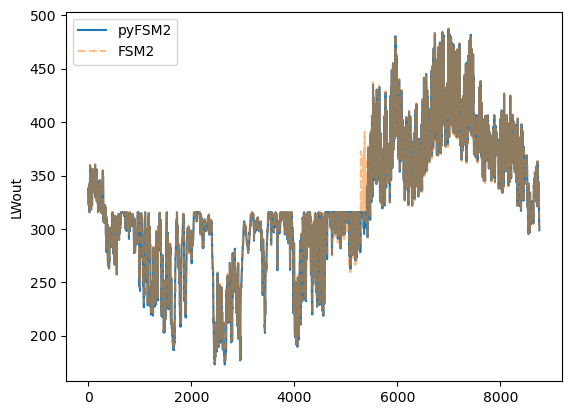

In [ ]:
plt.plot(LWoutlist, label='pyFSM2')
plt.plot(outf.iloc[:,6].values, linestyle='--', alpha=0.5, label='FSM2')
plt.legend()
plt.ylabel('LWout')

Text(0, 0.5, 'FSM2')

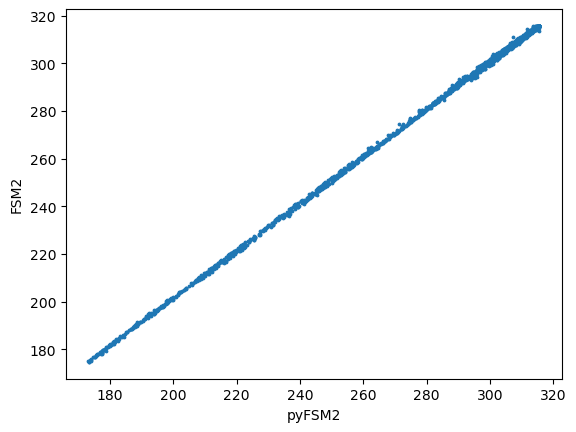

In [ ]:
plt.scatter(LWoutlist[2000:4000], outf.iloc[2000:4000,6].values, s=3)
plt.xlabel('pyFSM2')
plt.ylabel('FSM2')

Text(0, 0.5, 'Melt')

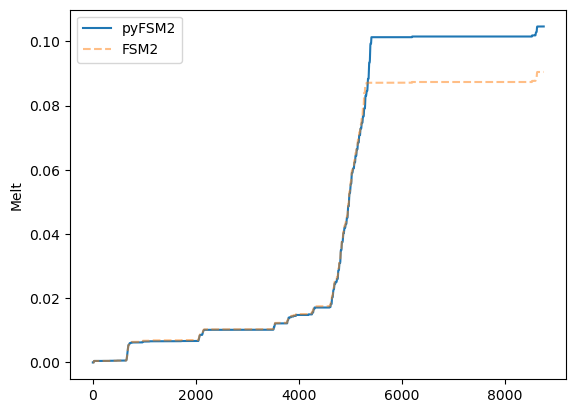

In [ ]:
plt.plot(np.cumsum(Meltlist), label='pyFSM2')
plt.plot(np.cumsum(outf.iloc[:,7].values), linestyle='--', alpha=0.5, label='FSM2')
plt.legend()
plt.ylabel('Melt')

Text(0, 0.5, 'FSM2')

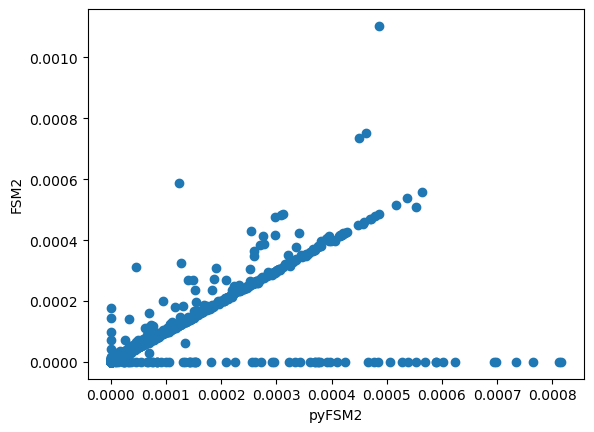

In [ ]:
plt.scatter(Meltlist, outf.iloc[:,7].values)
plt.xlabel('pyFSM2')
plt.ylabel('FSM2')

Text(0, 0.5, 'Roff')

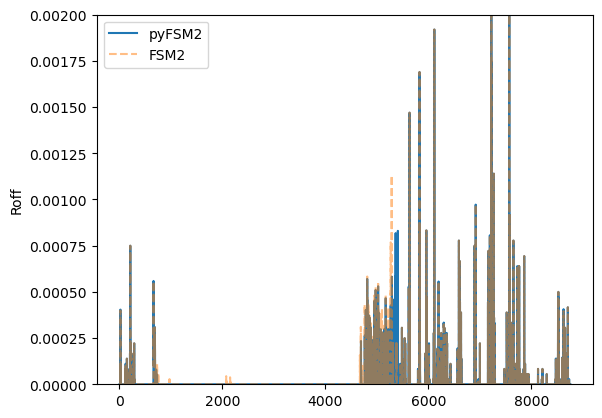

In [ ]:
plt.plot(Rofflist, label='pyFSM2')
plt.plot(outf.iloc[:,8].values, linestyle='--', alpha=0.5, label='FSM2')
plt.ylim([0, 0.002])
plt.legend()
plt.ylabel('Roff')

Text(0, 0.5, 'Cumulated Subl')

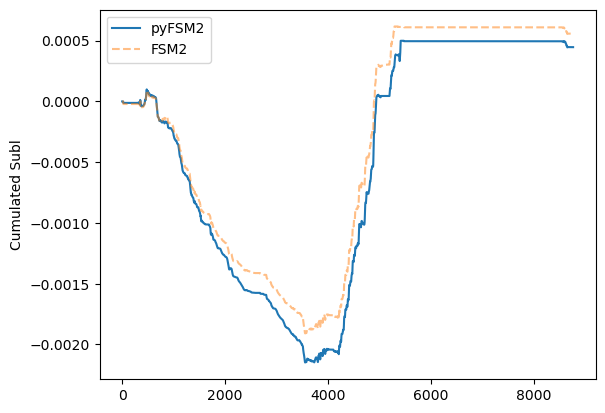

In [ ]:
plt.plot(np.cumsum(subllist), label='pyFSM2')
plt.plot(np.cumsum(outf.iloc[:,9].values), linestyle='--', alpha=0.5, label='FSM2')
plt.legend()
plt.ylabel('Cumulated Subl')

Text(0, 0.5, 'FSM2')

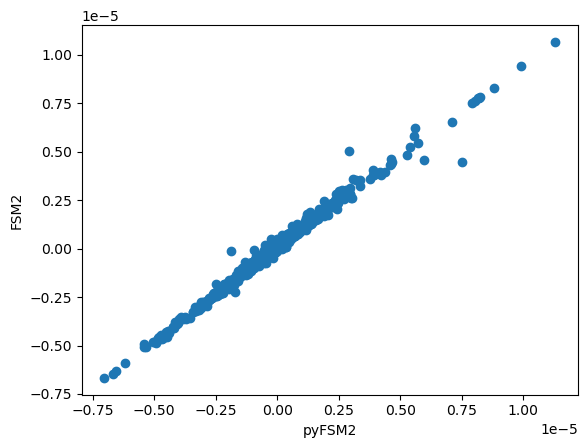

In [ ]:
plt.scatter(subllist[2000:4000], outf.iloc[2000:4000,9].values)
plt.xlabel('pyFSM2')
plt.ylabel('FSM2')

Text(0, 0.5, 'SWout')

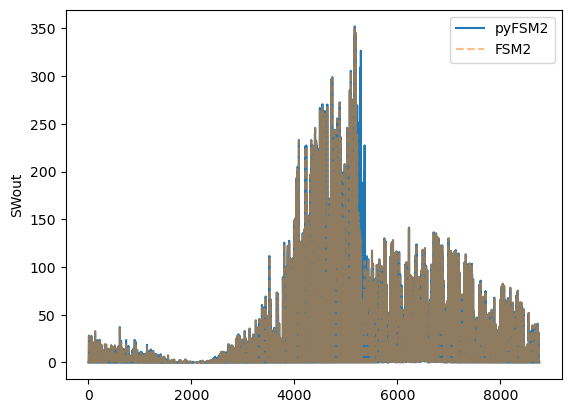

In [ ]:
plt.plot(SWoutlist, label='pyFSM2')
plt.plot(outf.iloc[:,10].values, linestyle='--', alpha=0.5, label='FSM2')
plt.legend()
plt.ylabel('SWout')

Text(0, 0.5, 'FSM2')

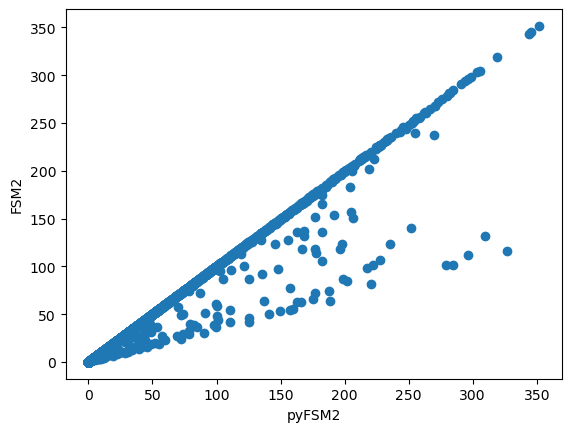

In [ ]:
plt.scatter(SWoutlist, outf.iloc[:,10].values)
plt.xlabel('pyFSM2')
plt.ylabel('FSM2')